In [1]:
from pathlib import Path

import cv2
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from shapely import Polygon

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

ox.settings.use_cache = True
ox.settings.log_console = False


def to_h3(x: str, res: int) -> str:
    t = map(float, x[1:-1].split(", "))
    return h3.geo_to_h3(*t, res)

In [2]:
RES = 10
CRS = 3857
output = "../output/dallas"
figures = "../figures/dallas"

In [3]:
try:
    data = pd.read_csv(f"{output}/h3_res{RES}.csv", engine="pyarrow")
except FileNotFoundError:
    # 4m
    df = pd.read_csv("../data/dwf/DFW_Feb_Mar_2021_1h.csv", engine="pyarrow")
    df.set_index("Date", inplace=True)
    df.head(3)

    long_df = pd.melt(df.reset_index(), id_vars=["Date"], value_vars=df.columns)
    long_df.columns = ["data", "userid", "location"]

    for i in range(6, 11):
        long_df[f"h3_{i}"] = long_df["location"].apply(lambda x: to_h3(x, i))

        dd = (
            long_df.groupby(f"h3_{i}")["userid"].agg(["count", "nunique"]).reset_index()
        )

        dd.to_csv(f"../output/dallas/h3_res{i}.csv", index=False)
    data = pd.read_csv(f"{output}/h3_res{RES}.csv", engine="pyarrow")
finally:
    data["geometry"] = data[f"h3_{RES}"].apply(
        lambda x: Polygon(tuple(map(tuple, map(reversed, h3.h3_to_geo_boundary(x)))))
    )
    data = gpd.GeoDataFrame(data, geometry="geometry", crs=4326)

In [4]:
data_crs = data.to_crs(CRS)

In [5]:
minx_, miny_, maxx_, maxy_ = data_crs.unary_union.bounds
minx_, miny_, maxx_, maxy_
minx = np.floor((minx_ / 1000)) * 1000
maxx = np.ceil((maxx_ / 1000)) * 1000
miny = np.floor((miny_ / 1000)) * 1000
maxy = np.ceil((maxy_ / 1000)) * 1000

print(minx, miny, maxx, maxy)

area = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])
area_wgs84 = gpd.GeoDataFrame(geometry=[area], crs=CRS).to_crs(4326).geometry[0]

large = area.buffer(500000).envelope
large_crs = gpd.GeoDataFrame(geometry=[large], crs=CRS).geometry[0]
large_wgs84 = gpd.GeoDataFrame(geometry=[large], crs=CRS).to_crs(4326).geometry[0]

-10907000.0 3786000.0 -10679000.0 3973000.0


In [6]:
# make the large area square
clip_area = Polygon(
    [
        (large_crs.bounds[0] + 40000, large_crs.bounds[1]),
        (large_crs.bounds[2], large_crs.bounds[1]),
        (large_crs.bounds[2], large_crs.bounds[3]),
        (large_crs.bounds[0] + 40000, large_crs.bounds[3]),
    ]
)

In [7]:
square_area = Polygon(
    [
        (minx + 20000, miny),
        (maxx - 20000, miny),
        (maxx - 20000, maxy),
        (minx + 20000, maxy),
    ]
)
figsize = (
    (square_area.bounds[2] - square_area.bounds[0]) / 10000,
    (square_area.bounds[3] - square_area.bounds[1]) / 10000,
)

if not Path(f"{figures}/count.png").exists():
    fig = plt.figure(figsize=figsize, dpi=100)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.clip(data_crs, square_area).plot(fc="k", ec="none", lw=0, ax=ax)
    ax.axis("off")
    ax.margins(0)
    fig.savefig(
        f"{figures}/count.png",
        pad_inches=0,
        bbox_inches="tight",
        metadata=config["metadata"],
    )

if not Path(f"{figures}/nunique.png").exists():
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.clip(data_crs, square_area).plot(column="nunique", ax=ax, cmap="binary")
    ax.axis("off")
    ax.margins(0)
    fig.savefig(
        f"{figures}/nunique.png",
        pad_inches=0,
        bbox_inches="tight",
        metadata=config["metadata"],
    )

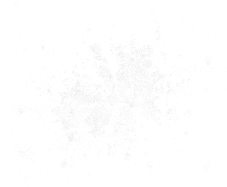

In [8]:
fig = plt.figure(figsize=((maxx - minx) / 1000, (maxy - miny) / 1000), dpi=1)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
# data_crs.plot(fc="k", ec="none", lw=0, ax=ax)
data_crs.plot(column="count", ax=ax, cmap="binary")
ax.axis("off")
ax.margins(0)
fig.savefig(
    f"{figures}/count_res{RES}.png",
    pad_inches=0,
    bbox_inches="tight",
    metadata=config["metadata"],
)

In [9]:
try:
    landuse = pd.read_pickle(f"{output}/landuse_wgs84.pickle")
except FileNotFoundError:
    # 8m 30s
    landuse = ox.features_from_polygon(
        large_wgs84, tags={"landuse": ["residential", "retail", "industrial"]}
    )
    landuse = landuse[landuse["geometry"].geom_type == "Polygon"].copy()
    # landuse.to_crs(CRS, inplace=True)
    landuse.to_pickle(f"{output}/landuse_wgs84.pickle")
finally:
    landuse = landuse.to_crs(CRS)

In [10]:
W = (clip_area.bounds[2] - clip_area.bounds[0]) / 1000
H = (clip_area.bounds[3] - clip_area.bounds[1]) / 1000
print(W, H)

1188.0 1187.0


In [11]:
if not Path(f"{figures}/landuse.png").exists():
    fig_lu = plt.figure(figsize=(W, H), dpi=1)
    ax_lu = fig_lu.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    gpd.clip(landuse, clip_area).plot(color="k", ax=ax_lu)
    ax_lu.axis("off")
    ax_lu.margins(0)
    fig_lu.savefig(
        f"{figures}/landuse.png",
        pad_inches=0,
        # bbox_inches="tight",
        metadata=config["metadata"],
    )

(462, 504)


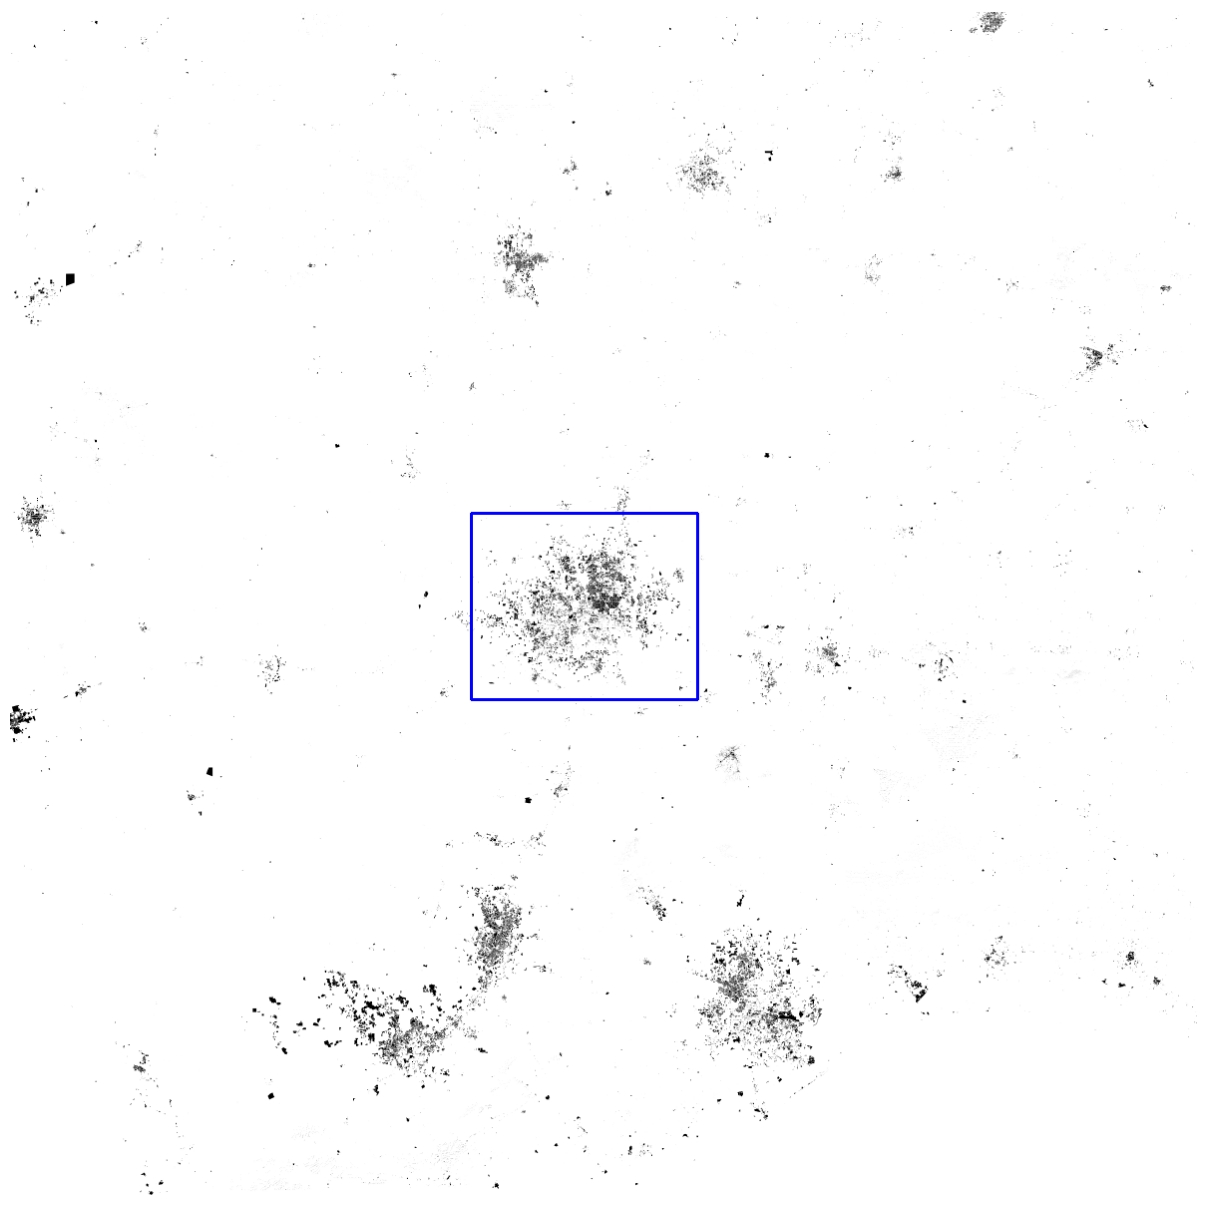

In [12]:
large_image = cv2.imread(f"{figures}/landuse.png")
template = cv2.imread(f"{figures}/count_res{RES}.png")

method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(large_image, template, method)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Step 2: Get the size of the template. This is the same size as the match.
# trows, tcols = template.shape[:2]
tcols, trows = template.shape[:2]

# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc
bottom_right = (top_left[0] + trows, top_left[1] + tcols)
print(top_left)

# Step 3: Draw the rectangle on large_image
cv2.rectangle(large_image, top_left, bottom_right, (0, 0, 255), 2)

fig2 = plt.figure(figsize=(W / 100, H / 100), dpi=100)
ax2 = fig2.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax2.imshow(large_image)
ax2.axis("off")
ax2.margins(0)
fig2.patch.set_visible(False)
fig2.savefig(
    f"{figures}/location_{RES}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [13]:
startx = clip_area.bounds[0] + (top_left[0] * 1000)
starty = clip_area.bounds[3] - (top_left[1] * 1000)
print(startx, starty)

with open(f"{output}/anchor_res{RES}.yaml", "w") as fp:
    yaml.dump(
        {
            "top_left": {"x": round(startx, 3), "y": round(starty, 3)},
            "area": {
                "bounds": {
                    "minx": area.bounds[0],
                    "maxx": area.bounds[2],
                    "miny": area.bounds[1],
                    "maxy": area.bounds[3],
                }
            },
        },
        fp,
    )

-10905000.0 3969000.0


In [14]:
area.bounds

(-10907000.0, 3786000.0, -10679000.0, 3973000.0)